<img src = "Data/bgsedsc_0.jpg">

In [67]:
## Set up ----
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns

import random
import time
import scipy
import datetime
import pandas as pd
import numpy as np
import sklearn
import pandas as pd
import numpy as np
import time

from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler, OneHotEncoder,  scale
import category_encoders as ce
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# kernel approximators
from sklearn.kernel_approximation import Nystroem, RBFSampler

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import gc
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

# Random state
rand_state = 1111
np.random.seed(rand_state) # impose random seed for reproducibility

# Some base models
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import mlens
from mlens.visualization import corrmat
from mlens.ensemble import SuperLearner, BlendEnsemble, Subsemble, SequentialEnsemble, TemporalEnsemble

# Training dataset
data=pd.read_csv('../Data/mimic_train.csv')
data_test=pd.read_csv('../Data/mimic_test_los.csv')

# Ensembles

This notebook continues on from the related [notebook](2_decision-trees.ipynb) on decision trees - the main notebook. In this notebook we just ensemble different regression methods to see if we can arraive at improved predictions. On the face of it, in-sample estimates suggest that ensembling should improve predictions. In particular averaging appears to perform a good job. And yet when submitting ensemble predictions to Kaggle I generally got surprisingly bad outcomes. 

## 1) Pre-processing

As discussed in the notebook on decision trees, all preprocessing has been moved into a separate [notebook](1_preproc.ipynb). To run the preprocessing from here simply uncomment and run the below:

In [68]:
#%run ./preproc.ipynb

In [69]:
# Read pre-processed data:
y = data.loc[:,'LOS']
X = pd.read_csv("../Data/los/X_preproc.csv")
X_test = pd.read_csv("../Data/los/X_test_preproc.csv")
data = pd.concat([y,X], axis=1)

In [70]:
# Check:
print(X.shape)
print(X_test.shape)
print(y.shape)

(20885, 36)
(5221, 36)
(20885,)


In [71]:
# Train test split
from sklearn.model_selection import train_test_split

X_train, X_test ,y_train, y_test = train_test_split(
    np.array(X),
    y, 
    test_size=0.7, random_state=rand_state
)

target_name = 'LOS'
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

## 2) Prediction

I use a set of basic models including XGBoost and LightGBM. For the latter I use whatever parameter values yielded optimal results for standalone prediction in the decision tree notebook.

In [72]:
def get_models():
    #Generate a library of simple learners
    svr = SVR(C=100)
    knn = KNeighborsRegressor(n_neighbors=3)
    rf = RandomForestRegressor(n_estimators=10, max_features=3, random_state=rand_state)
    lr = LinearRegression()
    xgb = XGBRegressor(
        learning_rate=0.05, 
        objective='reg:squarederror', 
        n_estimators=100, 
        subsample=0.5, 
        max_depth=6
    )
    lgbm = LGBMRegressor(
        learning_rate=0.05, 
        n_estimators=100, 
        subsample=0.8, 
        max_depth=9,
        num_leaves=40
    )
    models = {
        'svm': svr,
        'knn': knn,
        'random forest': rf,
        'linear reg': lr,
        'xgb': xgb,
        'lgbm': lgbm
    }
    return models

def train_predict(model_list,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test):

    if y_test is None:
        P = np.zeros((X_test.shape[0], len(model_list)))
        P = pd.DataFrame(P)
    else:
        P = np.zeros((y_test.shape[0], len(model_list)))
        P = pd.DataFrame(P)

    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(X_train, y_train)
        P.iloc[:, i] = m.predict(X_test)
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    # Score model in test set
    print("Scoring models.")
    scores=[]
    for m in P.columns:
        score = np.sqrt(mean_squared_error(y, P.loc[:, m]))
        scores.append(score)
        print("%-26s: %.3f" % (m, score))
    return P.columns,scores

First let us look at the correlations between the different model predictions. Unsurprisingly, correlation between predictions from XGBoost and LightGBM are highly correlated (though clearly not perfectly correlated, so indeed it makes sense to look consider both approaches.)

svm... done
knn... done
random forest... done
linear reg... done
xgb... done
lgbm... done
Done.

Scoring models.
svm                       : 4.792
knn                       : 5.302
random forest             : 4.996
linear reg                : 4.611
xgb                       : 4.690
lgbm                      : 4.639


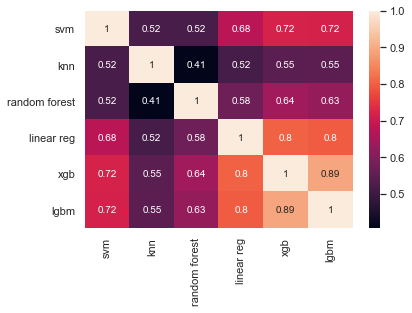

In [73]:
models = get_models()
P = train_predict(models,X_train,y_train,X_test,y_test)
my_models,my_scores= score_models(P, y_test)
#Plot correlations
sns.heatmap(P.corr(), annot=True)
plt.show()

Initialize a `results` list to store the accuracy scores:

In [74]:
# Save results
predictions = P
results=[(model,score) for model,score in zip(my_models,my_scores)]
results

[('svm', 4.792223165272498),
 ('knn', 5.302407696226023),
 ('random forest', 4.995624292915001),
 ('linear reg', 4.611313081387308),
 ('xgb', 4.6897159649581015),
 ('lgbm', 4.6393937085230945)]

The results for the different ensemble methods are all shown below. Most of if it is self-explanatory and the main discussion was given upfront at the top. 

### 2.1) Averaging

We will begin by simply averaging the predictions and add the resulting score to the results. We actually get quite a bit of improvement here, likely due to the fact that KNN predictions are so different from the others.

In [75]:
# Simple average
AvgPred=pd.DataFrame(P.mean(axis=1),columns=['Avg'])
my_model_avg,my_scores_avg= score_models(AvgPred, y_test)

Scoring models.
Avg                       : 4.606


In [76]:
# Save results
results=results+[(model,score) for model,score in zip(my_model_avg,my_scores_avg)]
predictions['Avg'] =AvgPred
results

[('svm', 4.792223165272498),
 ('knn', 5.302407696226023),
 ('random forest', 4.995624292915001),
 ('linear reg', 4.611313081387308),
 ('xgb', 4.6897159649581015),
 ('lgbm', 4.6393937085230945),
 ('Avg', 4.6057244568706395)]

### 2.2) Stacking

Stacking does not lead to much improvement:

In [77]:
meta_learner = ExtraTreesRegressor(
    n_estimators=20,
    bootstrap=True,
    max_features=0.7
)

# Instantiate the ensemble with 5 folds (stacking meta-learner)
sl = SuperLearner(
    folds=5,
    verbose=2
)

# Add the base learners and the meta learner
sl.add(list(models.values()))
sl.add_meta(meta_learner)

# Train the ensemble
sl.fit(X_train, y_train)

# Predict the test set
y_hat = sl.predict(X_test)
scoreStackXtres=np.sqrt(mean_squared_error(y_test, y_hat))
print("\nSuper Learner RMSE: %.3f" % scoreStackXtres)


Fitting 2 layers
Processing layer-1             done | 00:02:00
Processing layer-2             done | 00:00:00
Fit complete                        | 00:02:01

Predicting 2 layers
Processing layer-1             done | 00:00:10
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:11

Super Learner RMSE: 4.823


In [78]:
# Save results
results=results+[('StackingExtraTrees',scoreStackXtres)]
predictions['StackingExtraTrees'] = y_hat
results

[('svm', 4.792223165272498),
 ('knn', 5.302407696226023),
 ('random forest', 4.995624292915001),
 ('linear reg', 4.611313081387308),
 ('xgb', 4.6897159649581015),
 ('lgbm', 4.6393937085230945),
 ('Avg', 4.6057244568706395),
 ('StackingExtraTrees', 4.823039034717141)]

### 2.3) Feature propagation

Let's try to propagate the most important features (as per the random forest model):

In [79]:
n_features = 5
rf_features = models['random forest'].feature_importances_
rf_features_ordered = pd.Series(data=rf_features, index=range(len(rf_features))).sort_values(ascending=False)
to_propagate = list(rf_features_ordered[:n_features].index)
pointer = to_propagate

Evidently this leads to improvement with stacking:

In [80]:
sl2 = SuperLearner(
    folds=5,
    random_state=rand_state,
    verbose=2
)

# Add the base learners and the meta learner
sl2.add(list(models.values()), proba=False, propagate_features=pointer)
sl2.add_meta(meta_learner, proba=False)

# Train the ensemble
sl2.fit(X_train, y_train)

# Predict the test set
y_hat = sl2.predict(X_test)
scoreStackXtres2=np.sqrt(mean_squared_error(y_test, y_hat))
print("\nSuper Learner 2 RMSE: %.3f" % scoreStackXtres2)


Fitting 2 layers
Processing layer-1             done | 00:01:32
Processing layer-2             done | 00:00:00
Fit complete                        | 00:01:33

Predicting 2 layers
Processing layer-1             done | 00:00:10
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:10

Super Learner 2 RMSE: 4.831


In [81]:
# Save results
results=results+[('StackingExtraTrees2',scoreStackXtres2)]
predictions['StackingExtraTrees2'] = y_hat
results

[('svm', 4.792223165272498),
 ('knn', 5.302407696226023),
 ('random forest', 4.995624292915001),
 ('linear reg', 4.611313081387308),
 ('xgb', 4.6897159649581015),
 ('lgbm', 4.6393937085230945),
 ('Avg', 4.6057244568706395),
 ('StackingExtraTrees', 4.823039034717141),
 ('StackingExtraTrees2', 4.830518248966535)]

### 2.4) Blending

In [82]:
bl =  BlendEnsemble(test_size=0.2, random_state=rand_state,n_jobs=3)

# Add the base learners and the meta learner
bl.add(list(models.values()), proba=False, propagate_features=pointer)
bl.add_meta(meta_learner, proba=False)

# Train the ensemble
bl.fit(X_train, y_train)

# Predict the test set
y_hat = bl.predict(X_test)
scoreBlendXtrees=np.sqrt(mean_squared_error(y_test, y_hat))
print("\nBlend RMSE: %.3f" % scoreBlendXtrees)


Blend RMSE: 4.746


In [83]:
# Save results
results=results+[('BlendXtrees',scoreBlendXtrees)]
predictions['BlendXtrees'] = y_hat
results

[('svm', 4.792223165272498),
 ('knn', 5.302407696226023),
 ('random forest', 4.995624292915001),
 ('linear reg', 4.611313081387308),
 ('xgb', 4.6897159649581015),
 ('lgbm', 4.6393937085230945),
 ('Avg', 4.6057244568706395),
 ('StackingExtraTrees', 4.823039034717141),
 ('StackingExtraTrees2', 4.830518248966535),
 ('BlendXtrees', 4.745918401636478)]

### 2.5) Subsemple

In [84]:
from sklearn.cluster import KMeans
sub = Subsemble(partitions=3, folds=4,partition_estimator=KMeans(3, random_state=rand_state),
               random_state=rand_state)

sub.add(list(models.values()), proba=False, propagate_features=pointer)
sub.add_meta(meta_learner, proba=False)

# Train the ensemble
sub.fit(X_train, y_train)

# Predict the test set
y_hat = sub.predict(X_test)
scoreSubS=np.sqrt(mean_squared_error(y_test, y_hat))
print("\nSubSamble RMSE: %.3f" % scoreSubS)


SubSamble RMSE: 4.956


In [85]:
# Save results
results=results+[('SubSambleXtrees',scoreSubS)]
predictions['SubSambleXtrees'] = y_hat
results

[('svm', 4.792223165272498),
 ('knn', 5.302407696226023),
 ('random forest', 4.995624292915001),
 ('linear reg', 4.611313081387308),
 ('xgb', 4.6897159649581015),
 ('lgbm', 4.6393937085230945),
 ('Avg', 4.6057244568706395),
 ('StackingExtraTrees', 4.823039034717141),
 ('StackingExtraTrees2', 4.830518248966535),
 ('BlendXtrees', 4.745918401636478),
 ('SubSambleXtrees', 4.955859754272324)]

### 2.6) Multi-layer

Let's define a second meta learner and run a multi-layer ensemble:

In [86]:
meta_learner_2 = RandomForestRegressor()

In [87]:
ensemble = SequentialEnsemble(random_state=rand_state)

# The initial layer is a blended layer, same as a layer in the BlendEnsemble
ensemble.add('blend',
             list(models.values()), proba=False, propagate_features=pointer,random_state=rand_state)

# The second layer is a stacked layer, same as a layer of the SuperLearner
ensemble.add('stack', [meta_learner, meta_learner_2], proba=False,random_state=rand_state)

# The third layer is a subsembled layer, same as a layer of the Subsemble
ensemble.add('subsemble', [meta_learner, meta_learner_2], proba=False,random_state=rand_state)

# The meta estimator is added as in any other ensemble
ensemble.add_meta(LinearRegression(), proba=False)
# Train the ensemble
ensemble.fit(X_train, y_train)

# Predict the test set
y_hat = ensemble.predict(X_test)
scoreMultiE=np.sqrt(mean_squared_error(y_test, y_hat))
print("\nMulti-Ensemble RMSE: %.3f" % scoreMultiE)


Multi-Ensemble RMSE: 4.817


In [88]:
# Save results
results=results+[('Multi-Layer',scoreMultiE)]
predictions['Multi-Layer'] = y_hat
results

[('svm', 4.792223165272498),
 ('knn', 5.302407696226023),
 ('random forest', 4.995624292915001),
 ('linear reg', 4.611313081387308),
 ('xgb', 4.6897159649581015),
 ('lgbm', 4.6393937085230945),
 ('Avg', 4.6057244568706395),
 ('StackingExtraTrees', 4.823039034717141),
 ('StackingExtraTrees2', 4.830518248966535),
 ('BlendXtrees', 4.745918401636478),
 ('SubSambleXtrees', 4.955859754272324),
 ('Multi-Layer', 4.817499178500809)]

## 3) Model evaluation with test set



In [89]:
results_df=pd.DataFrame(results)
results_df.columns=['Method','RMSE']
results_df= results_df.sort_values(by='RMSE', ascending=True)
results_df.head()

,Method,RMSE
6,Avg,4.605724
3,linear reg,4.611313
5,lgbm,4.639394
4,xgb,4.689716
9,BlendXtrees,4.745918


(4.5, 5.0)

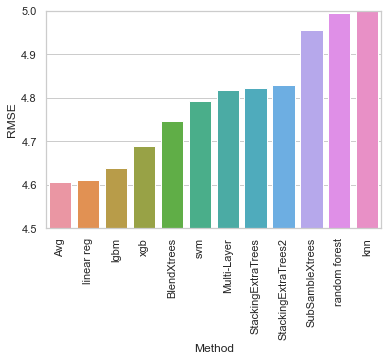

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
ax = sns.barplot(x="Method", y="RMSE", data=results_df)
ax= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.ylim(4.5,5)

In [91]:
results_df = results_df.reset_index(drop=True)
best_method = results_df.loc[0,'Method']

## 4) Final prediction and export

Finally, we can use the full training sample to fit the model and then predict from the test sample. Since averaging looks most promising I try that.

In [94]:
y = data.loc[:,'LOS']
X = pd.read_csv("../Data/los/X_preproc.csv")
X_test = pd.read_csv("../Data/los/X_test_preproc.csv")
y_hat_all = train_predict(models,X,y,X_test,y_test=None)
y_hat=pd.DataFrame(y_hat_all.mean(axis=1),columns=['Avg'])
cols,final_score= score_models(AvgPred, y_test)

svm... done
knn... done
random forest... done
linear reg... done
xgb... done
lgbm... done
Done.

Scoring models.
Avg                       : 4.606


Also given the surprisingly strong performance of linear regression I give that a try too.

In [95]:
chosen_ensemble = 'Avg'
data_test=pd.read_csv('../Data/mimic_test_death.csv')
predictions = pd.DataFrame({'icustay_id': data_test.icustay_id.values, 'LOS': y_hat.Avg})
output_name = f"output/ensmbl_predictions_score:{final_score[0]}" 
predictions.to_csv(output_name, index=False)
predictions.describe()

,icustay_id,LOS
count,5221.000000,5221.000000
mean,249925.293239,3.540838
std,28763.030681,2.126519
min,200011.000000,-0.012345
25%,225118.000000,2.156558
50%,249759.000000,3.010332
75%,274576.000000,4.370604
max,299979.000000,60.314885


In [102]:
lin_reg = y_hat_all.loc[:,'linear reg'].values
predictions = pd.DataFrame({'icustay_id': data_test.icustay_id.values, 'LOS': lin_reg})
output_name = f"output/lin_reg_predictions_score:{final_score[0]}" 
predictions.to_csv(output_name, index=False)
predictions.describe()

,icustay_id,LOS
count,5221.000000,5221.000000
mean,249925.293239,3.777785
std,28763.030681,4.891725
min,200011.000000,-4.231871
25%,225118.000000,2.256996
50%,249759.000000,3.398310
75%,274576.000000,4.900275
max,299979.000000,321.456777
